In [27]:
import pandas as pd
import numpy as np

In [28]:
df = pd.read_csv('reddit_sentiment_data_models.csv')
df.shape

(55546, 12)

### Derive indicators
* Engagement ratio = Number of comments / Score

In [29]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Set multiple index for date and stock
df = df.set_index(['date', 'stock'])

# Create total sentiment for each model
models = ['stanza', 'roberta', 'longformer']
for model in models:
    title_col = f'title_score_{model}'
    body_col = f'body_score_{model}'
    if title_col in df.columns and body_col in df.columns:
        df[f'total_sentiment_{model}'] = df[title_col] + df[body_col]
    else:
        print(f"Warning: Missing columns for {model} model")

# Aggregate by date and stock (sum all posts for same stock on same day)
df = df.groupby(['date', 'stock']).agg('sum')

# Set score to 1 if it is less than 1 to avoid division by zero
df['score'] = np.where(df['score'] < 1, 1, df['score'])

# Add column engagement_ratio
df['engagement_ratio'] = df['comms_num'] / df['score']

# Convert back to proper index format
df = df.reset_index()
df = df.set_index(['date', 'stock'])

print("Available sentiment columns:")
sentiment_cols = [col for col in df.columns if 'total_sentiment' in col]
print(sentiment_cols)

Available sentiment columns:
['total_sentiment_stanza', 'total_sentiment_roberta', 'total_sentiment_longformer']


### Aggregate Monthly and calculate average sentiment for the month
#### Filter strategy
* Top 5 "Sentiment" stocks (Not good in return (22-Apr done)
* Top 5 "Engagement" stocks (Return similar to QQQ in the beginning, then became loss) (27-Apr done)

In [21]:
df.head()

title  score  \
date       stock                                                             
2021-01-28 AA                       RH unable to tradeAA pre market     11   
           AAL    AAL, AMC, EXPR, GME, NOK - The Ride to the Moo...    972   
           ADMA                                                Adma      2   
           AG     Once you're done with GME - $AG and $SLV, the ...      1   
           AGI                            Charitably-Minded Autists    282   

                  comms_num  \
date       stock              
2021-01-28 AA             5   
           AAL          218   
           ADMA           0   
           AG            16   
           AGI           42   

                                                               body  \
date       stock                                                      
2021-01-28 AA     Anyone else unable to trade in Robinhood, GME,...   
           AAL    Guys it’s simple.  If you’re selling YOURE hur...   
           ADMA         ADMA only US plasma publicly traded company   
           AG     You guys are champs. GME... who would have tho...   
           AGI    Probably doesn't belong here, but I honestly d...   

                  title_score_stanza  body_score_stanza  title_score_roberta  \
date       stock                                                               
2021-01-28 AA                    2.0                  2                    1   
           AAL                  13.0                  6                   17   
           ADMA                  1.0                  1                    1   
           AG                    1.0                  1                    1   
           AGI                   1.0                  1                    0   

                  body_score_roberta  title_score_longformer  \
date       stock                                               
2021-01-28 AA                      3                       6   
           AAL                     5                      23   
           ADMA                    1                       2   
           AG                      0                       0   
           AGI                     1                       2   

                  body_score_longformer  total_sentiment_stanza  \
date       stock                                                  
2021-01-28 AA                         0                     4.0   
           AAL                       26                    19.0   
           ADMA                       2                     2.0   
           AG                         0                     2.0   
           AGI                        0                     2.0   

                  total_sentiment_roberta  total_sentiment_longformer  \
date       stock                                                        
2021-01-28 AA                           4                           6   
           AAL                         22                          49   
           ADMA                         2                           4   
           AG                           1                           0   
           AGI                          1                           2   

                  engagement_ratio  
date       stock                    
2021-01-28 AA             0.454545  
           AAL            0.224280  
           ADMA           0.000000  
           AG            16.000000  
           AGI            0.148936

In [30]:
# Function to filter strategy for any indicator with historical data validation
def filter_strategy(df, indicator, available_stocks=None):
    # Aggregate monthly using the specified indicator
    df_agg = (df.reset_index('stock').groupby([pd.Grouper(freq='ME'), 'stock'])[[indicator]].mean())
    
    # Rank based on specific indicator
    df_agg['rank'] = (df_agg.groupby(level=0)[indicator].transform(lambda x: x.rank(ascending=False).astype(int)))
    
    # If we have available stocks list, ensure we get exactly 5 valid stocks
    if available_stocks is not None:
        df_final = pd.DataFrame()
        
        for date in df_agg.index.get_level_values(0).unique():
            month_data = df_agg.xs(date, level=0).sort_values('rank')
            selected_stocks = []
            
            # Try to get 5 stocks with historical data
            for _, row in month_data.iterrows():
                stock = row.name  # stock is the index name
                if stock in available_stocks and len(selected_stocks) < 5:
                    selected_stocks.append(stock)
            
            # If we couldn't get 5 stocks, fill with best available
            if len(selected_stocks) < 5:
                remaining_stocks = [s for s in month_data.index if s in available_stocks and s not in selected_stocks]
                selected_stocks.extend(remaining_stocks[:5-len(selected_stocks)])
            
            # Create dataframe for this month with selected stocks
            if selected_stocks:
                month_filtered = month_data.loc[selected_stocks].copy()
                month_filtered['rank'] = range(1, len(month_filtered) + 1)  # Re-rank from 1 to N
                month_filtered = month_filtered.reset_index()
                month_filtered['date'] = date
                month_filtered = month_filtered.set_index(['date', 'stock'])
                df_final = pd.concat([df_final, month_filtered])
        
        df_filtered = df_final
    else:
        # Original logic - filter out top 5 ranking without validation
        df_filtered = df_agg[df_agg['rank'] <= 5].copy()
    
    # Adjust date to be the first day of the month
    df_filtered = df_filtered.reset_index('stock')
    df_filtered.index = df_filtered.index + pd.DateOffset(1)
    df_filtered = df_filtered.reset_index().set_index(['date', 'stock'])
    
    return df_filtered

# Test with one model first
indicator = 'total_sentiment_roberta'
if indicator in df.columns:
    df_filtered_roberta = filter_strategy(df, indicator)
    print(f"Filtered data shape for {indicator}: {df_filtered_roberta.shape}")
else:
    print(f"Column {indicator} not found in dataframe")

Filtered data shape for total_sentiment_roberta: (40, 2)


### Extract the stocks to form portfolios with at the start of each new month
* Create a dictionary containing start of month and corresponded selected stocks.

In [41]:
# Create portfolios for four different indicators across all three sentiment models
models = ['stanza', 'roberta', 'longformer']
indicators = {
    'score': 'score',  # Most upvotes
    'comments': 'comms_num',  # Most number of comments
    'engagement': 'engagement_ratio',  # Engagement ratio
    'total_sentiment_stanza': 'total_sentiment_stanza',  # Sentiment for Stanza
    'total_sentiment_roberta': 'total_sentiment_roberta',  # Sentiment for RoBERTa
    'total_sentiment_longformer': 'total_sentiment_longformer'  # Sentiment for Longformer
}

portfolios = {}
all_stocks = set()

# First pass: collect all unique stocks without validation for each indicator
print("First pass: Collecting all potential stocks for each indicator...")
for indicator_name, indicator_col in indicators.items():
    if indicator_col in df.columns:
        # Filter strategy for this indicator
        df_filtered = filter_strategy(df, indicator_col)
        
        # Extract all stocks mentioned
        dates = df_filtered.index.get_level_values('date').unique().to_list()
        for date in dates:
            stocks = df_filtered.xs(date, level=0).index.tolist()
            all_stocks.update(stocks)
        
        print(f"{indicator_name}: {len(dates)} months, {len(df_filtered.index.get_level_values('stock').unique())} unique stocks")
    else:
        print(f"Warning: {indicator_col} not found in data")

print(f"\nTotal unique stocks across all indicators: {len(all_stocks)}")

# Store temporary portfolios for later validation
portfolios_temp = {}
for indicator_name, indicator_col in indicators.items():
    if indicator_col in df.columns:
        df_filtered = filter_strategy(df, indicator_col)
        dates = df_filtered.index.get_level_values('date').unique().to_list()
        fixed_dates = {}
        for date in dates:
            stocks = df_filtered.xs(date, level=0).index.tolist()
            fixed_dates[date.strftime('%Y-%m-%d')] = stocks
        
        portfolios_temp[indicator_name] = fixed_dates

print("Sample portfolio for score indicator:")
if 'score' in portfolios_temp:
    sample_dates = list(portfolios_temp['score'].keys())[:3]
    for date in sample_dates:
        print(f"  {date}: {portfolios_temp['score'][date]}")

First pass: Collecting all potential stocks for each indicator...
score: 8 months, 30 unique stocks
comments: 8 months, 24 unique stocks
engagement: 8 months, 39 unique stocks
total_sentiment_stanza: 8 months, 18 unique stocks
total_sentiment_roberta: 8 months, 20 unique stocks
total_sentiment_longformer: 8 months, 18 unique stocks

Total unique stocks across all indicators: 93
Sample portfolio for score indicator:
  2021-02-01: ['AMC', 'BB', 'EDIT', 'GME', 'YOU']
  2021-03-01: ['AMC', 'DD', 'EL', 'GME', 'GMED']
  2021-04-01: ['DD', 'GME', 'OC', 'RARE', 'SIG']


### Download the fresh stock prices for only selected/shortlisted stocks
* Calculate cumulative log returns (Time-additive)

In [32]:
# List all unique stocks across all models
stock_list = list(all_stocks)
print(f"Loading historical data for {len(stock_list)} stocks")
print(f"Sample stocks: {stock_list[:10]}")

Loading historical data for 93 stocks
Sample stocks: ['OC', 'FOUR', 'SOL', 'ROOT', 'UWMC', 'SF', 'MVIS', 'DMA', 'SD', 'BB']


In [44]:
# Set date range
start = pd.to_datetime("2021-03-01").strftime('%Y-%m-%d')
end = pd.to_datetime("2021-08-31").strftime('%Y-%m-%d')

# Load historical stock data
df_all = pd.DataFrame()
missing_stocks = []
available_stocks = []

for ticker in stock_list:
    try:
        # Read CSV, skip first 3 rows (header info), use manual column names
        df_temp = pd.read_csv(f'stock_historical_prices_2019-2024/{ticker}.csv', 
                             skiprows=3, 
                             names=['Date', 'Close', 'High', 'Low', 'Open', 'Volume'])
        df_temp['Date'] = pd.to_datetime(df_temp['Date'])
        df_temp = df_temp.set_index('Date')[start:end]['Close'].to_frame(ticker)
        
        # Check if we have valid data (not all NaN)
        if not df_temp[ticker].isna().all():
            available_stocks.append(ticker)
            df_all = pd.concat([df_all, df_temp], axis=1)
        else:
            print(f'Warning: {ticker} has no valid data in date range')
            missing_stocks.append(ticker)
    except Exception as e:
        print(f'Error reading {ticker}.csv: {e}')
        missing_stocks.append(ticker)

# Calculate log returns
df_return = np.log(df_all.astype('float64')).diff().dropna(how='all')

print(f"Total stocks attempted: {len(stock_list)}")
print(f"Successfully loaded with valid data: {len(available_stocks)}")
print(f"Missing or invalid stock files: {len(missing_stocks)}")
print(f"Return data shape: {df_return.shape}")
print(f"Date range: {df_return.index.min()} to {df_return.index.max()}")

# Now recreate portfolios with validation using available stocks for ALL indicators
print(f"\nRecreating portfolios with validation using {len(available_stocks)} available stocks...")
portfolios = {}

for indicator_name, indicator_col in indicators.items():
    if indicator_col in df.columns:
        # Filter strategy for this indicator WITH validation
        df_filtered = filter_strategy(df, indicator_col, available_stocks=set(available_stocks))
        
        # Extract portfolio dates and stocks
        dates = df_filtered.index.get_level_values('date').unique().to_list()
        fixed_dates = {}
        stocks_per_month = []
        
        for date in dates:
            stocks = df_filtered.xs(date, level=0).index.tolist()
            fixed_dates[date.strftime('%Y-%m-%d')] = stocks
            stocks_per_month.append(len(stocks))
        
        portfolios[indicator_name] = fixed_dates
        print(f"{indicator_name}: {len(dates)} months, avg {np.mean(stocks_per_month):.1f} stocks per month")
        
        # Check if we consistently get 5 stocks
        if len(set(stocks_per_month)) == 1 and stocks_per_month[0] == 5:
            print(f"  ✓ Successfully gets exactly 5 stocks every month")
        else:
            print(f"  ⚠ Variable stocks per month: {set(stocks_per_month)}")
    else:
        print(f"Warning: {indicator_col} not found in data")

print("Sample validated portfolio for score indicator:")
if 'score' in portfolios:
    sample_dates = list(portfolios['score'].keys())[:3]
    for date in sample_dates:
        stocks = portfolios['score'][date]
        print(f"  {date}: {stocks} ({len(stocks)} stocks)")

Total stocks attempted: 93
Successfully loaded with valid data: 84
Missing or invalid stock files: 9
Return data shape: (128, 84)
Date range: 2021-03-02 00:00:00 to 2021-08-31 00:00:00

Recreating portfolios with validation using 84 available stocks...
score: 8 months, avg 5.0 stocks per month
  ✓ Successfully gets exactly 5 stocks every month
comments: 8 months, avg 5.0 stocks per month
  ✓ Successfully gets exactly 5 stocks every month
engagement: 8 months, avg 5.0 stocks per month
  ✓ Successfully gets exactly 5 stocks every month
total_sentiment_stanza: 8 months, avg 5.0 stocks per month
  ✓ Successfully gets exactly 5 stocks every month
score: 8 months, avg 5.0 stocks per month
  ✓ Successfully gets exactly 5 stocks every month
comments: 8 months, avg 5.0 stocks per month
  ✓ Successfully gets exactly 5 stocks every month
engagement: 8 months, avg 5.0 stocks per month
  ✓ Successfully gets exactly 5 stocks every month
total_sentiment_stanza: 8 months, avg 5.0 stocks per month
  ✓ 

In [48]:
# Create portfolio returns dataframe with time series data for all indicators
print("Creating portfolio returns dataframe with time series data...")

# Initialize the main portfolio returns dataframe
portfolio_returns_df = pd.DataFrame(index=df_return.index)

# Calculate daily returns for each indicator
for indicator_name in portfolios.keys():
    print(f"Calculating daily returns for {indicator_name}...")
    
    # Initialize series to store daily portfolio returns
    daily_returns = pd.Series(index=df_return.index, dtype=float, name=f'{indicator_name}_returns')
    
    for rebalance_date, stocks in portfolios[indicator_name].items():
        month_start = pd.to_datetime(rebalance_date)
        month_end = month_start + pd.DateOffset(months=1) - pd.DateOffset(days=1)
        
        # Get actual date range available for this month
        available_dates = df_return.index
        period_dates = available_dates[(available_dates >= month_start) & (available_dates <= month_end)]
        
        if len(period_dates) > 0:
            # Calculate equal-weighted portfolio returns for this period
            period_returns = df_return.loc[period_dates, stocks].mean(axis=1)
            daily_returns.loc[period_dates] = period_returns
    
    # Add to main dataframe
    portfolio_returns_df[f'{indicator_name}_returns'] = daily_returns

# Add S&P 500 benchmark returns
if df_qqq_returns is not None:
    print("Adding S&P 500 (QQQ) benchmark returns...")
    
    # Align QQQ returns with our date range
    qqq_aligned = df_qqq_returns['QQQ'].reindex(df_return.index)
    portfolio_returns_df['sp500_returns'] = qqq_aligned
else:
    print("QQQ data not available for benchmark")

# Calculate cumulative returns for plotting
portfolio_cumulative_df = (1 + portfolio_returns_df.fillna(0)).cumprod()

print(f"Portfolio returns dataframe shape: {portfolio_returns_df.shape}")
print(f"Date range: {portfolio_returns_df.index.min()} to {portfolio_returns_df.index.max()}")
print(f"Available indicators: {[col.replace('_returns', '') for col in portfolio_returns_df.columns if col.endswith('_returns')]}")

# Show sample of the dataframe
print("\nSample of portfolio returns dataframe:")
print(portfolio_returns_df.head())

# Calculate summary statistics
print("\nSummary Statistics (Daily Returns):")
for col in portfolio_returns_df.columns:
    if portfolio_returns_df[col].notna().sum() > 0:
        mean_return = portfolio_returns_df[col].mean()
        std_return = portfolio_returns_df[col].std()
        sharpe_ratio = mean_return / std_return if std_return > 0 else 0
        print(f"{col:30}: Mean: {mean_return:.4f}, Std: {std_return:.4f}, Sharpe: {sharpe_ratio:.4f}")

# Also create the monthly aggregated returns for comparison
print("\nMonthly aggregated peak returns (for comparison):")
monthly_peak_returns = {}
monthly_final_returns = {}

for indicator_name in portfolios.keys():
    peaks = []
    finals = []
    
    for rebalance_date, stocks in portfolios[indicator_name].items():
        month_start = pd.to_datetime(rebalance_date)
        month_end = month_start + pd.DateOffset(months=1) - pd.DateOffset(days=1)
        
        # Get cumulative returns for this month
        available_dates = df_return.index
        period_dates = available_dates[(available_dates >= month_start) & (available_dates <= month_end)]
        
        if len(period_dates) > 0:
            period_returns = df_return.loc[period_dates, stocks].mean(axis=1)
            cumulative_returns = (1 + period_returns).cumprod()
            
            peak_return = cumulative_returns.max() - 1
            final_return = cumulative_returns.iloc[-1] - 1
            
            peaks.append(peak_return)
            finals.append(final_return)
    
    monthly_peak_returns[indicator_name] = peaks
    monthly_final_returns[indicator_name] = finals
    print(f"{indicator_name}: Avg Peak: {np.mean(peaks):.3f}, Avg Final: {np.mean(finals):.3f}")

# Store both for plotting options
all_returns = monthly_final_returns
peak_returns = monthly_peak_returns

Creating portfolio returns dataframe with time series data...
Calculating daily returns for score...
Calculating daily returns for comments...
Calculating daily returns for engagement...
Calculating daily returns for total_sentiment_stanza...
Calculating daily returns for total_sentiment_roberta...
Calculating daily returns for total_sentiment_longformer...
Adding S&P 500 (QQQ) benchmark returns...
Portfolio returns dataframe shape: (128, 7)
Date range: 2021-03-02 00:00:00 to 2021-08-31 00:00:00
Available indicators: ['score', 'comments', 'engagement', 'total_sentiment_stanza', 'total_sentiment_roberta', 'total_sentiment_longformer', 'sp500']

Sample of portfolio returns dataframe:
            score_returns  comments_returns  engagement_returns  \
Date                                                              
2021-03-02      -0.014985         -0.002792            0.000392   
2021-03-03       0.003726          0.000067           -0.025060   
2021-03-04      -0.012226         -0.0087

In [42]:
# Check what benchmark data we have available
print("Available columns in df_return:")
print(f"Total columns: {len(df_return.columns)}")
print("Sample columns:", df_return.columns[:10].tolist())

# Check for QQQ specifically
if 'QQQ' in df_return.columns:
    print("✓ QQQ found in data")
    print(f"QQQ data range: {df_return['QQQ'].dropna().index.min()} to {df_return['QQQ'].dropna().index.max()}")
    print(f"QQQ non-null values: {df_return['QQQ'].notna().sum()}/{len(df_return)}")
else:
    print("✗ QQQ not found in data")
    print("Looking for alternative benchmarks...")
    potential_benchmarks = ['SPY', 'VOO', 'AAPL', 'MSFT', 'GOOGL']
    for ticker in potential_benchmarks:
        if ticker in df_return.columns:
            print(f"  ✓ Found {ticker}")
        else:
            print(f"  ✗ {ticker} not available")

# Let's try to load QQQ data separately if needed
import os
if os.path.exists('market_indexes_2019-2024/QQQ.csv'):
    print("\nFound QQQ.csv file, loading separately...")
    df_qqq = pd.read_csv('market_indexes_2019-2024/QQQ.csv', skiprows=3, 
                        names=['Date', 'Close', 'High', 'Low', 'Open', 'Volume'])
    df_qqq['Date'] = pd.to_datetime(df_qqq['Date'])
    df_qqq = df_qqq.set_index('Date')[start:end]['Close'].to_frame('QQQ')
    df_qqq_returns = np.log(df_qqq.astype('float64')).diff().dropna()
    print(f"QQQ data loaded: {len(df_qqq_returns)} return observations")
    print(f"Date range: {df_qqq_returns.index.min()} to {df_qqq_returns.index.max()}")
else:
    print("QQQ.csv file not found in market_indexes_2019-2024/")
    # Use SPY as backup or create synthetic benchmark
    df_qqq_returns = None

Available columns in df_return:
Total columns: 84
Sample columns: ['OC', 'FOUR', 'SOL', 'ROOT', 'UWMC', 'SF', 'MVIS', 'SD', 'BB', 'ROKU']
✗ QQQ not found in data
Looking for alternative benchmarks...
  ✗ SPY not available
  ✗ VOO not available
  ✗ AAPL not available
  ✗ MSFT not available
  ✗ GOOGL not available

Found QQQ.csv file, loading separately...
QQQ data loaded: 128 return observations
Date range: 2021-03-02 00:00:00 to 2021-08-31 00:00:00


In [39]:
# Calculate portfolio returns for all three models
portfolio_returns = {}

for model in models:
    if model in portfolios:
        print(f"Calculating returns for {model} model...")
        df_portfolio = pd.DataFrame()
        
        for start_date in portfolios[model].keys():
            # Find next month end as end date
            end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
            tickers = portfolios[model][start_date]
            
            # Filter tickers that exist in our return data
            available_tickers = [t for t in tickers if t in df_return.columns]
            
            if available_tickers:
                # Calculate equal-weighted portfolio return for this period
                df_temp = df_return[start_date:end_date][available_tickers].mean(axis=1).to_frame(f'portfolio_return_{model}')
                df_portfolio = pd.concat([df_portfolio, df_temp], axis=0)
            else:
                print(f"Warning: No available tickers for {start_date} in {model} model")
        
        df_portfolio.index = pd.to_datetime(df_portfolio.index)
        portfolio_returns[model] = df_portfolio
        print(f"  {model} portfolio shape: {df_portfolio.shape}")

print(f"\nSuccessfully created portfolios for {len(portfolio_returns)} models")


Successfully created portfolios for 0 models


### Download prices of NASDAQ / QQQ and calculate returns to compare to our strategy

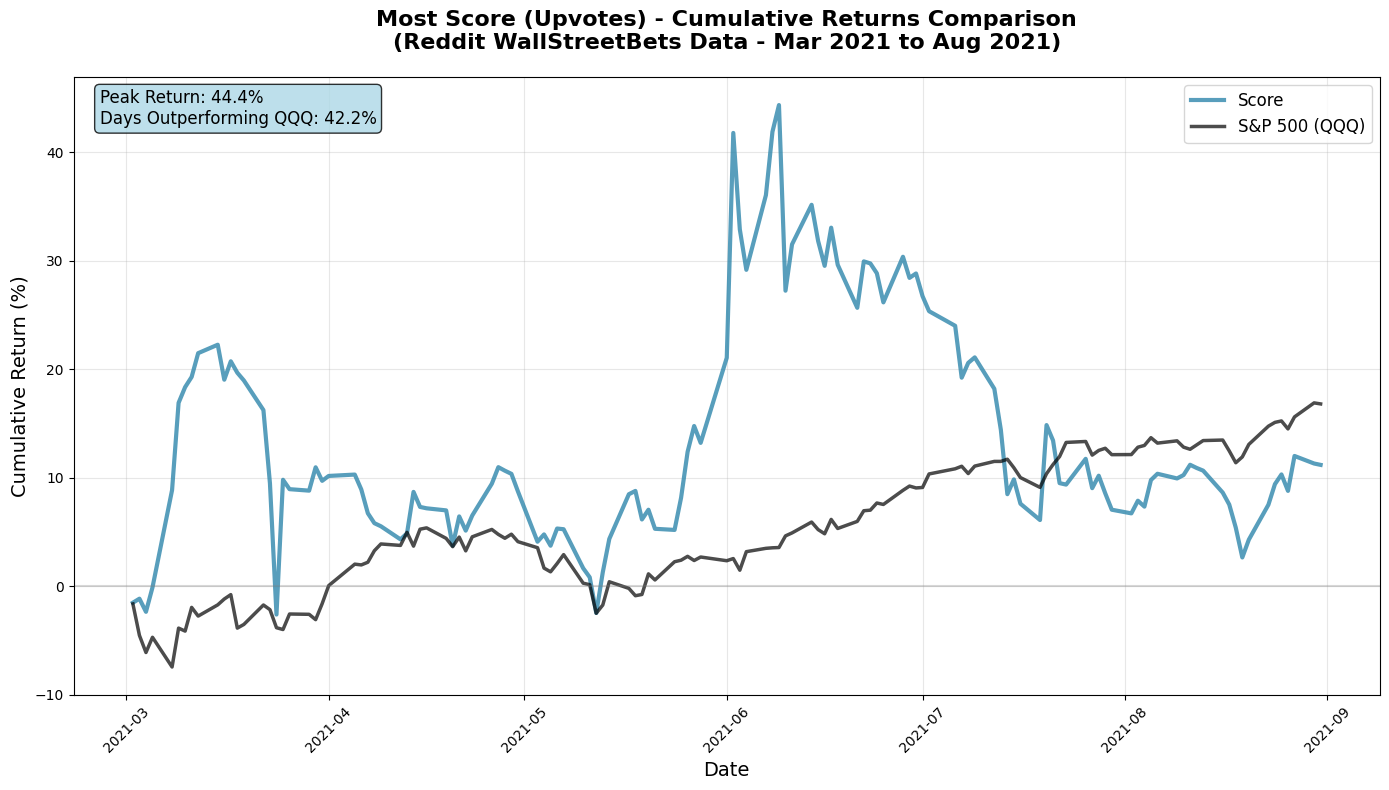

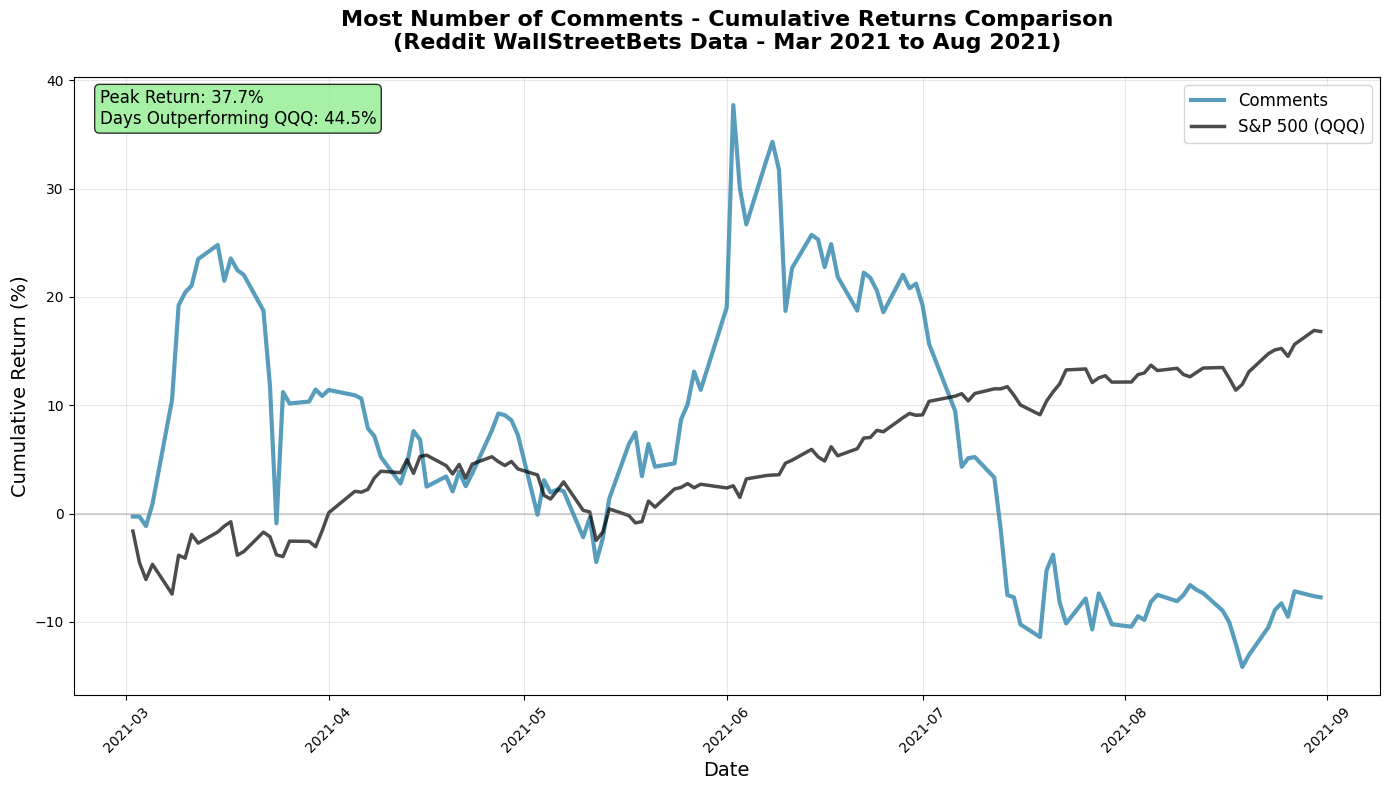

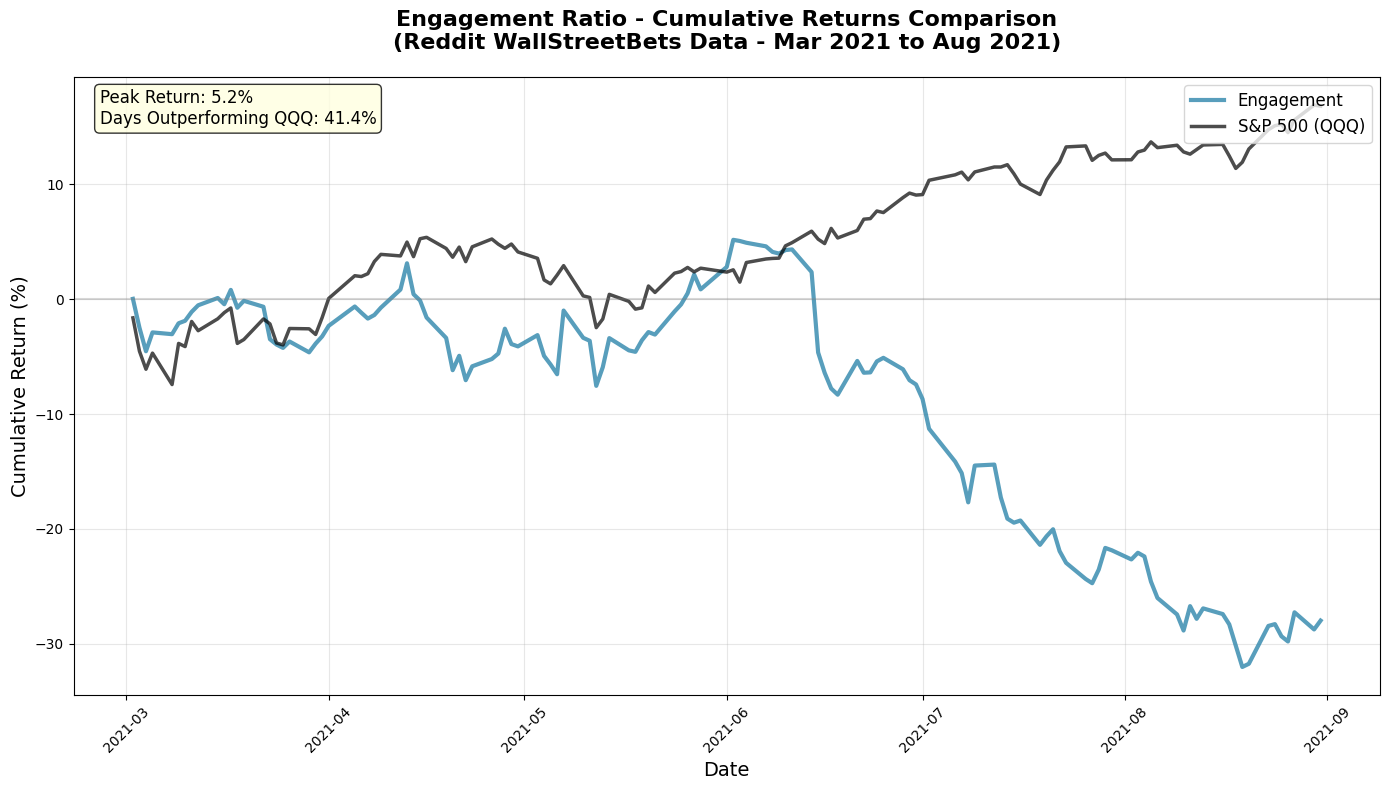

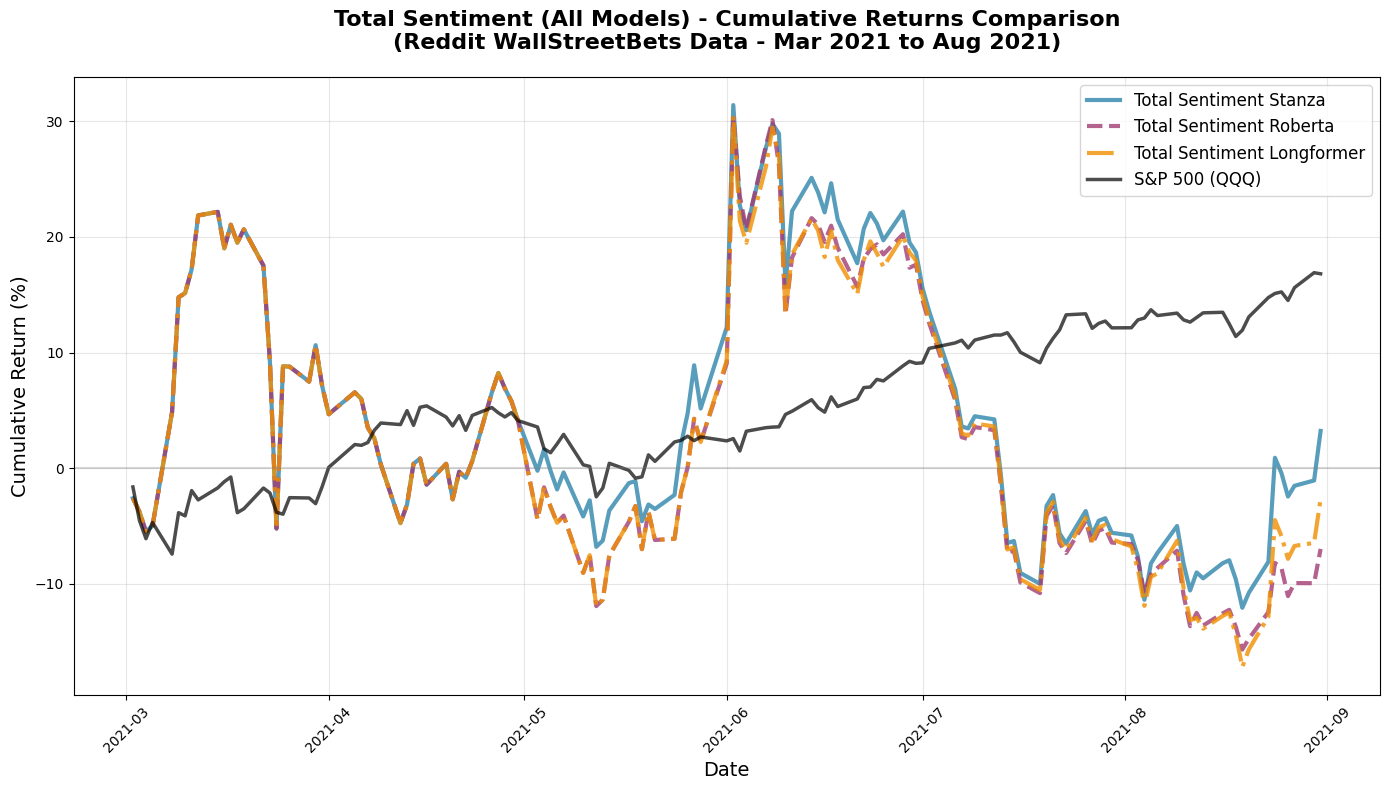


PORTFOLIO RETURNS SUMMARY - TIME SERIES DATA

Most Score (Upvotes):
  Score                    : Final 11.2%, Peak 44.4%, Days > QQQ 42.2%
  Group Average            : Final 11.2%, Peak 44.4%, Days > QQQ 42.2%

Most Number of Comments:
  Comments                 : Final -7.7%, Peak 37.7%, Days > QQQ 44.5%
  Group Average            : Final -7.7%, Peak 37.7%, Days > QQQ 44.5%

Engagement Ratio:
  Engagement               : Final -28.0%, Peak 5.2%, Days > QQQ 41.4%
  Group Average            : Final -28.0%, Peak 5.2%, Days > QQQ 41.4%

Total Sentiment (All Models):
  Total Sentiment Stanza   : Final 3.2%, Peak 31.4%, Days > QQQ 43.8%
  Total Sentiment Roberta  : Final -7.0%, Peak 30.5%, Days > QQQ 44.5%
  Total Sentiment Longformer: Final -2.6%, Peak 30.5%, Days > QQQ 43.0%
  Group Average            : Final -2.1%, Peak 30.8%, Days > QQQ 43.8%


In [55]:
# Create four separate full-width plots using portfolio returns dataframe
import matplotlib.pyplot as plt
import numpy as np

# Define the four indicator categories - only sentiment has multiple ML models
indicator_groups = {
    'Most Score (Upvotes)': ['score'],  # Only score indicator
    'Most Number of Comments': ['comments'],  # Only comments indicator 
    'Engagement Ratio': ['engagement'],  # Only engagement indicator
    'Total Sentiment (All Models)': ['total_sentiment_stanza', 'total_sentiment_roberta', 'total_sentiment_longformer']  # Three ML models for sentiment
}

# Colors and styles for different indicators/models
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#8E44AD', '#27AE60']
markers = ['o', 's', '^', 'D', 'v', 'P']
line_styles = ['-', '--', '-.', ':', '-', '--']

# PLOT 1: Most Score (Upvotes)
plt.figure(figsize=(14, 8))
group_name = 'Most Score (Upvotes)'
indicators_in_group = indicator_groups[group_name]

for i, indicator in enumerate(indicators_in_group):
    col_name = f'{indicator}_returns'
    if col_name in portfolio_cumulative_df.columns:
        # Plot cumulative returns
        cumulative_returns = portfolio_cumulative_df[col_name].dropna()
        plt.plot(cumulative_returns.index, (cumulative_returns - 1) * 100, 
               color=colors[i], 
               linestyle=line_styles[i],
               linewidth=3,
               alpha=0.8,
               label=indicator.replace('_', ' ').title())

# Add S&P 500 benchmark
if 'sp500_returns' in portfolio_cumulative_df.columns:
    benchmark_cumulative = portfolio_cumulative_df['sp500_returns'].dropna()
    plt.plot(benchmark_cumulative.index, (benchmark_cumulative - 1) * 100,
           color='black',
           linestyle='-',
           linewidth=2.5,
           alpha=0.7,
           label='S&P 500 (QQQ)')

plt.title(f'{group_name} - Cumulative Returns Comparison\n(Reddit WallStreetBets Data - Mar 2021 to Aug 2021)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return (%)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(rotation=45)
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

# Add summary stats
for indicator in indicators_in_group:
    col_name = f'{indicator}_returns'
    if col_name in portfolio_cumulative_df.columns:
        final_return = (portfolio_cumulative_df[col_name].dropna().iloc[-1] - 1) * 100
        max_return = (portfolio_cumulative_df[col_name].dropna().max() - 1) * 100
        
        # Calculate percentage of days outperforming QQQ
        if 'sp500_returns' in portfolio_returns_df.columns:
            # Get daily returns for both portfolio and benchmark
            portfolio_daily = portfolio_returns_df[col_name].dropna()
            benchmark_daily = portfolio_returns_df['sp500_returns'].reindex(portfolio_daily.index).dropna()
            
            # Count days where portfolio return > benchmark return
            common_dates = portfolio_daily.index.intersection(benchmark_daily.index)
            if len(common_dates) > 0:
                outperformed_days = (portfolio_daily[common_dates] > benchmark_daily[common_dates]).sum()
                total_days = len(common_dates)
                outperformance_pct = (outperformed_days / total_days) * 100
            else:
                outperformance_pct = 0
        else:
            outperformance_pct = 0
            
        textstr = f'Peak Return: {max_return:.1f}%\nDays Outperforming QQQ: {outperformance_pct:.1f}%'
        props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
        plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=12,
                verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('plot_1_most_score_upvotes.png', dpi=300, bbox_inches='tight')
plt.show()

# PLOT 2: Most Number of Comments
plt.figure(figsize=(14, 8))
group_name = 'Most Number of Comments'
indicators_in_group = indicator_groups[group_name]

for i, indicator in enumerate(indicators_in_group):
    col_name = f'{indicator}_returns'
    if col_name in portfolio_cumulative_df.columns:
        cumulative_returns = portfolio_cumulative_df[col_name].dropna()
        plt.plot(cumulative_returns.index, (cumulative_returns - 1) * 100, 
               color=colors[i], 
               linestyle=line_styles[i],
               linewidth=3,
               alpha=0.8,
               label=indicator.replace('_', ' ').title())

# Add S&P 500 benchmark
if 'sp500_returns' in portfolio_cumulative_df.columns:
    benchmark_cumulative = portfolio_cumulative_df['sp500_returns'].dropna()
    plt.plot(benchmark_cumulative.index, (benchmark_cumulative - 1) * 100,
           color='black',
           linestyle='-',
           linewidth=2.5,
           alpha=0.7,
           label='S&P 500 (QQQ)')

plt.title(f'{group_name} - Cumulative Returns Comparison\n(Reddit WallStreetBets Data - Mar 2021 to Aug 2021)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return (%)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(rotation=45)
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

# Add summary stats
for indicator in indicators_in_group:
    col_name = f'{indicator}_returns'
    if col_name in portfolio_cumulative_df.columns:
        final_return = (portfolio_cumulative_df[col_name].dropna().iloc[-1] - 1) * 100
        max_return = (portfolio_cumulative_df[col_name].dropna().max() - 1) * 100
        
        # Calculate percentage of days outperforming QQQ
        if 'sp500_returns' in portfolio_returns_df.columns:
            # Get daily returns for both portfolio and benchmark
            portfolio_daily = portfolio_returns_df[col_name].dropna()
            benchmark_daily = portfolio_returns_df['sp500_returns'].reindex(portfolio_daily.index).dropna()
            
            # Count days where portfolio return > benchmark return
            common_dates = portfolio_daily.index.intersection(benchmark_daily.index)
            if len(common_dates) > 0:
                outperformed_days = (portfolio_daily[common_dates] > benchmark_daily[common_dates]).sum()
                total_days = len(common_dates)
                outperformance_pct = (outperformed_days / total_days) * 100
            else:
                outperformance_pct = 0
        else:
            outperformance_pct = 0
            
        textstr = f'Peak Return: {max_return:.1f}%\nDays Outperforming QQQ: {outperformance_pct:.1f}%'
        props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.8)
        plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=12,
                verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('plot_2_most_comments.png', dpi=300, bbox_inches='tight')
plt.show()

# PLOT 3: Engagement Ratio
plt.figure(figsize=(14, 8))
group_name = 'Engagement Ratio'
indicators_in_group = indicator_groups[group_name]

for i, indicator in enumerate(indicators_in_group):
    col_name = f'{indicator}_returns'
    if col_name in portfolio_cumulative_df.columns:
        cumulative_returns = portfolio_cumulative_df[col_name].dropna()
        plt.plot(cumulative_returns.index, (cumulative_returns - 1) * 100, 
               color=colors[i], 
               linestyle=line_styles[i],
               linewidth=3,
               alpha=0.8,
               label=indicator.replace('_', ' ').title())

# Add S&P 500 benchmark
if 'sp500_returns' in portfolio_cumulative_df.columns:
    benchmark_cumulative = portfolio_cumulative_df['sp500_returns'].dropna()
    plt.plot(benchmark_cumulative.index, (benchmark_cumulative - 1) * 100,
           color='black',
           linestyle='-',
           linewidth=2.5,
           alpha=0.7,
           label='S&P 500 (QQQ)')

plt.title(f'{group_name} - Cumulative Returns Comparison\n(Reddit WallStreetBets Data - Mar 2021 to Aug 2021)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return (%)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(rotation=45)
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

# Add summary stats
for indicator in indicators_in_group:
    col_name = f'{indicator}_returns'
    if col_name in portfolio_cumulative_df.columns:
        final_return = (portfolio_cumulative_df[col_name].dropna().iloc[-1] - 1) * 100
        max_return = (portfolio_cumulative_df[col_name].dropna().max() - 1) * 100
        
        # Calculate percentage of days outperforming QQQ
        if 'sp500_returns' in portfolio_returns_df.columns:
            # Get daily returns for both portfolio and benchmark
            portfolio_daily = portfolio_returns_df[col_name].dropna()
            benchmark_daily = portfolio_returns_df['sp500_returns'].reindex(portfolio_daily.index).dropna()
            
            # Count days where portfolio return > benchmark return
            common_dates = portfolio_daily.index.intersection(benchmark_daily.index)
            if len(common_dates) > 0:
                outperformed_days = (portfolio_daily[common_dates] > benchmark_daily[common_dates]).sum()
                total_days = len(common_dates)
                outperformance_pct = (outperformed_days / total_days) * 100
            else:
                outperformance_pct = 0
        else:
            outperformance_pct = 0
            
        textstr = f'Peak Return: {max_return:.1f}%\nDays Outperforming QQQ: {outperformance_pct:.1f}%'
        props = dict(boxstyle='round', facecolor='lightyellow', alpha=0.8)
        plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=12,
                verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('plot_3_engagement_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

# PLOT 4: Total Sentiment (All Models)
plt.figure(figsize=(14, 8))
group_name = 'Total Sentiment (All Models)'
indicators_in_group = indicator_groups[group_name]

for i, indicator in enumerate(indicators_in_group):
    col_name = f'{indicator}_returns'
    if col_name in portfolio_cumulative_df.columns:
        cumulative_returns = portfolio_cumulative_df[col_name].dropna()
        plt.plot(cumulative_returns.index, (cumulative_returns - 1) * 100, 
               color=colors[i], 
               linestyle=line_styles[i],
               linewidth=3,
               alpha=0.8,
               label=indicator.replace('_', ' ').title())

# Add S&P 500 benchmark
if 'sp500_returns' in portfolio_cumulative_df.columns:
    benchmark_cumulative = portfolio_cumulative_df['sp500_returns'].dropna()
    plt.plot(benchmark_cumulative.index, (benchmark_cumulative - 1) * 100,
           color='black',
           linestyle='-',
           linewidth=2.5,
           alpha=0.7,
           label='S&P 500 (QQQ)')

plt.title(f'{group_name} - Cumulative Returns Comparison\n(Reddit WallStreetBets Data - Mar 2021 to Aug 2021)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return (%)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(rotation=45)
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.savefig('plot_4_total_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

# Print overall summary using the portfolio dataframe
print("\n" + "="*80)
print("PORTFOLIO RETURNS SUMMARY - TIME SERIES DATA")
print("="*80)

for group_name, indicators_in_group in indicator_groups.items():
    print(f"\n{group_name}:")
    group_final_returns = []
    group_peak_returns = []
    group_outperformance_pcts = []
    
    for indicator in indicators_in_group:
        col_name = f'{indicator}_returns'
        if col_name in portfolio_cumulative_df.columns:
            cumulative = portfolio_cumulative_df[col_name].dropna()
            final_return = (cumulative.iloc[-1] - 1) * 100
            peak_return = (cumulative.max() - 1) * 100
            
            # Calculate percentage of days outperforming QQQ
            if 'sp500_returns' in portfolio_returns_df.columns:
                portfolio_daily = portfolio_returns_df[col_name].dropna()
                benchmark_daily = portfolio_returns_df['sp500_returns'].reindex(portfolio_daily.index).dropna()
                
                common_dates = portfolio_daily.index.intersection(benchmark_daily.index)
                if len(common_dates) > 0:
                    outperformed_days = (portfolio_daily[common_dates] > benchmark_daily[common_dates]).sum()
                    total_days = len(common_dates)
                    outperformance_pct = (outperformed_days / total_days) * 100
                else:
                    outperformance_pct = 0
            else:
                outperformance_pct = 0
            
            print(f"  {indicator.replace('_', ' ').title():25}: Final {final_return:.1f}%, Peak {peak_return:.1f}%, Days > QQQ {outperformance_pct:.1f}%")
            group_final_returns.append(final_return)
            group_peak_returns.append(peak_return)
            group_outperformance_pcts.append(outperformance_pct)
    
    if group_final_returns:
        avg_final = np.mean(group_final_returns)
        avg_peak = np.mean(group_peak_returns)
        avg_outperformance_pct = np.mean(group_outperformance_pcts)
        print(f"  {'Group Average':25}: Final {avg_final:.1f}%, Peak {avg_peak:.1f}%, Days > QQQ {avg_outperformance_pct:.1f}%")

print("="*80)